<a href="https://colab.research.google.com/github/malcolmlett/training-instrumentation-toolkit/blob/main/doc/train_explainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Instrumentation Toolkit: Train Explainer

The toolkit includes an experiment into automatic analytical explanation of zero and near-zero gradients.

This notebook illustrates that functionality, and explains the mathematical background.

In [4]:
# Install Training Instrumentation Toolkit
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import train_explainer as texpl
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets

# Run some unit tests
# (no formal packaging in the toolkit as yet, so just a rudimentary manual execution of tests)
import train_instrumentation_test
import train_explainer_test
import matmul_explainer_test
import conv_tools_test
train_instrumentation_test.run_test_suite()
conv_tools_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All conv_tools tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


## Motivation: Zero and Near-zero Gradients
While training a network, sometimes some of the unit gradients become zero. This isn't a problem if a small number are zero, but it becomes a problem when many are. When that does occur, a common practice is to guess what the cause is and to try out various documented methods to attempt to overcome the problem.

It would be much better if we can directly measure the cause of the zero gradients, as that should help us more find a solution more quickly and more accurately.

Additionally, zero gradients are usually the culmination of problems that occurred within the model training some number of steps or epochs beforehand. Observing and analysing _near-zero_ gradients can also help us.

There are actually many different ways in which gradients at a given layer can become zero, including but not limited to:
* the layer's pre-activation output values were largely negative, resulting in the ReLU activation producing many zero gradients.
* the layer's weights have all become tiny, resulting in zero or near-zero pre-activation outputs, perhaps due to a faulty loss function
* the layer's weights contain a balance of positive and negative, but in such a way that they cancel out
* the gradients in a later layer have collapsed, resulting in zero gradients being distributed to all earlier layers
* the model is misconfigured such that the layer doesn't contribute to the final model output and thus gradients don't flow back to the layer.

The first insight is that we could rule out some of the possibilities if we could directly measure some of the important quantities like the layer inputs, its weights and biases, its pre-activation outputs, and its post-activation outputs, and the backward pass gradients coming back from the next layer.

The second insight is that we can determine between some of the more subtle possibilities by classifying the per-element values of weights, gradients, etc. into just 3 classes: those that are positive, those that are negative, and those that are zero or near-zero.

The `train_explainer` module does all of that, and presents the results in a short text report.

## Instrumented Training Run
For this we'll need some real data from a training run. The `train_explainer` requires that we collect raw variable tensor data for the layer in question and also a little from its input layers:
* variables, gradients, outputs, output-gradients for target layer
* outputs for input layers

We'll train a model for a simple binary classification against the well known 'circles' dataset. This is the same setup used in the other doc notebooks. In particular, if you've gone through the _Visualisations_ notebook, you might have noticed that the second layer ended with around 60% dead neurons after 1000 epochs. Let's investigate that.

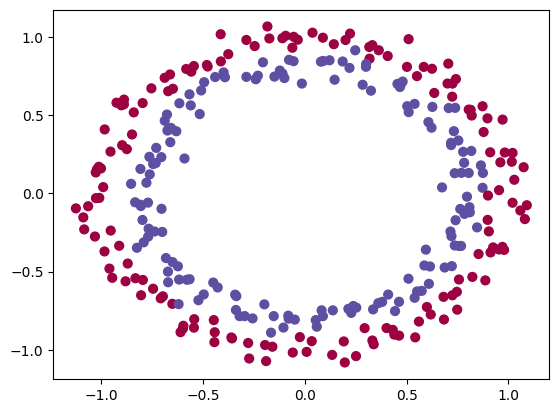

In [5]:
def binary_classification_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])
  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  return train_X, train_Y

train_X, train_Y = binary_classification_dataset()
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [32]:
target_layer_idx = 1

variables = tinstr.VariableHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx]}], before_updates=True)
gradients = tinstr.GradientHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx]}])
outputs = tinstr.LayerOutputHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx-1, target_layer_idx]}], batch_reduction=None)
output_gradients = tinstr.LayerOutputGradientHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx]}], batch_reduction=None)

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
history = tinstr.fit(model, dataset, epochs=1000, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

# PS: any tf.function retracing warnings can be safely ignored.

Epoch   100 - 308.10ms/epoch: accuracy: 0.9367  loss: 0.1675  mse: 0.0505  
Epoch   200 - 201.55ms/epoch: accuracy: 0.9800  loss: 0.0621  mse: 0.0165  
Epoch   300 - 206.72ms/epoch: accuracy: 0.9800  loss: 0.0356  mse: 0.0110  
Epoch   400 - 216.46ms/epoch: accuracy: 0.9767  loss: 0.0463  mse: 0.0136  
Epoch   500 - 203.34ms/epoch: accuracy: 0.9933  loss: 0.0170  mse: 0.0047  
Epoch   600 - 195.58ms/epoch: accuracy: 0.9867  loss: 0.0272  mse: 0.0088  
Epoch   700 - 223.78ms/epoch: accuracy: 0.9600  loss: 0.0977  mse: 0.0289  
Epoch   800 - 203.68ms/epoch: accuracy: 0.9900  loss: 0.0156  mse: 0.0046  
Epoch   900 - 193.40ms/epoch: accuracy: 0.9967  loss: 0.0111  mse: 0.0031  
Epoch  1000 - 204.58ms/epoch: accuracy: 1.0000  loss: 0.0026  mse: 0.0002  


First, let's confirm that there's a problem and narrow down its location...

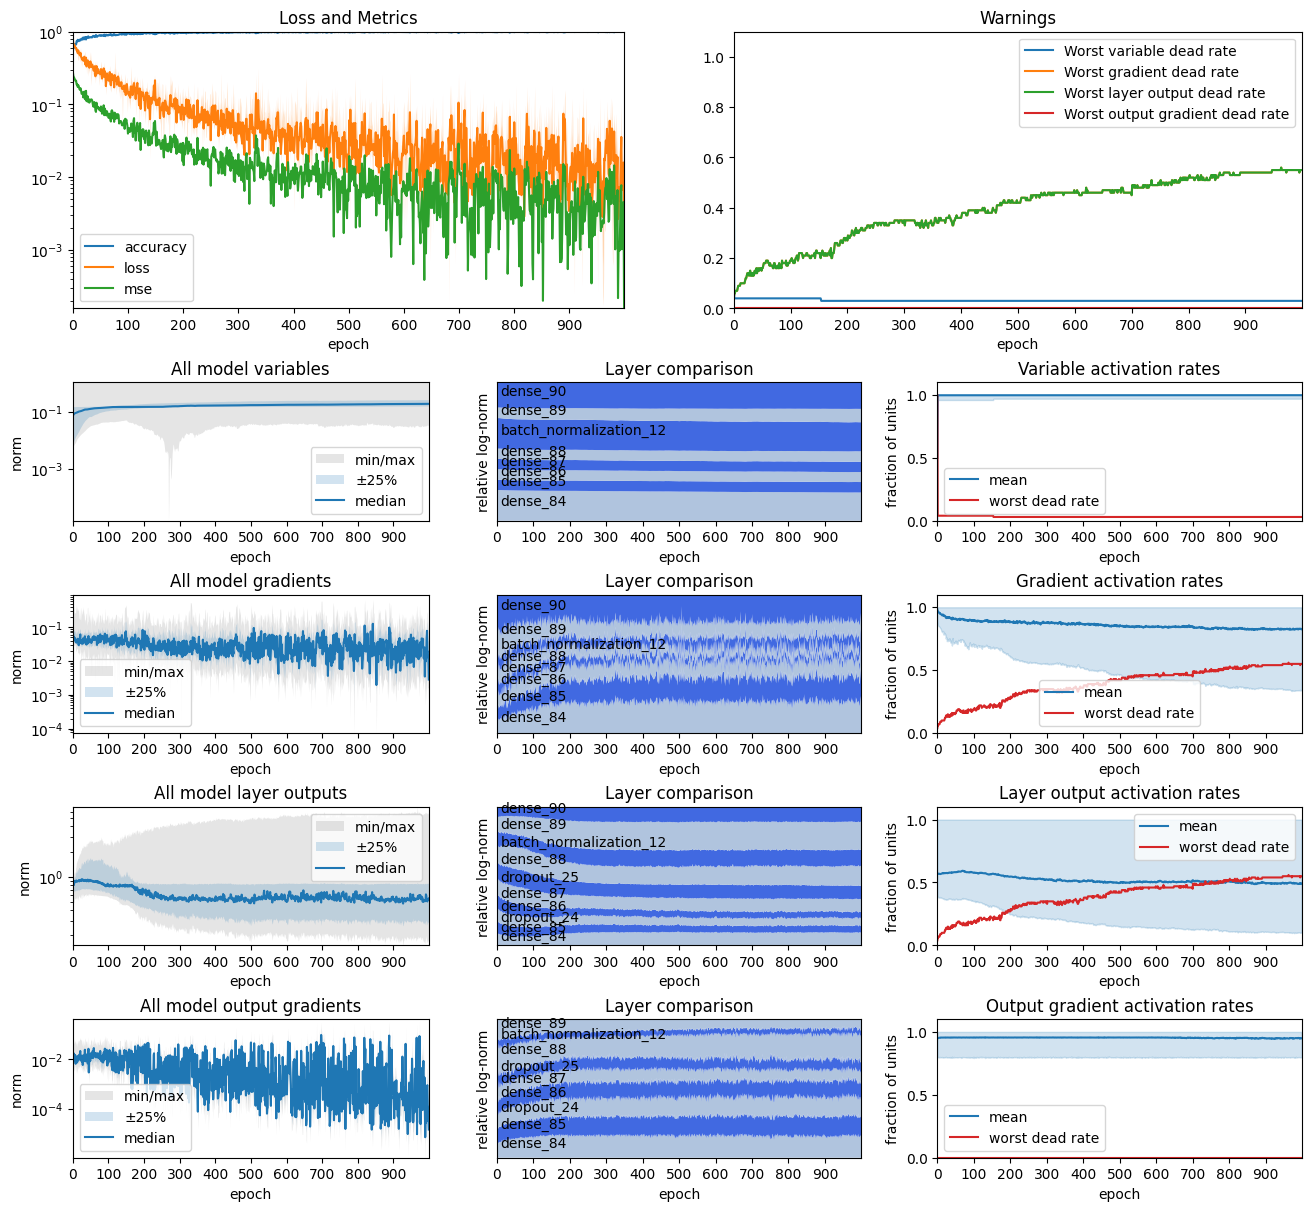

In [33]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

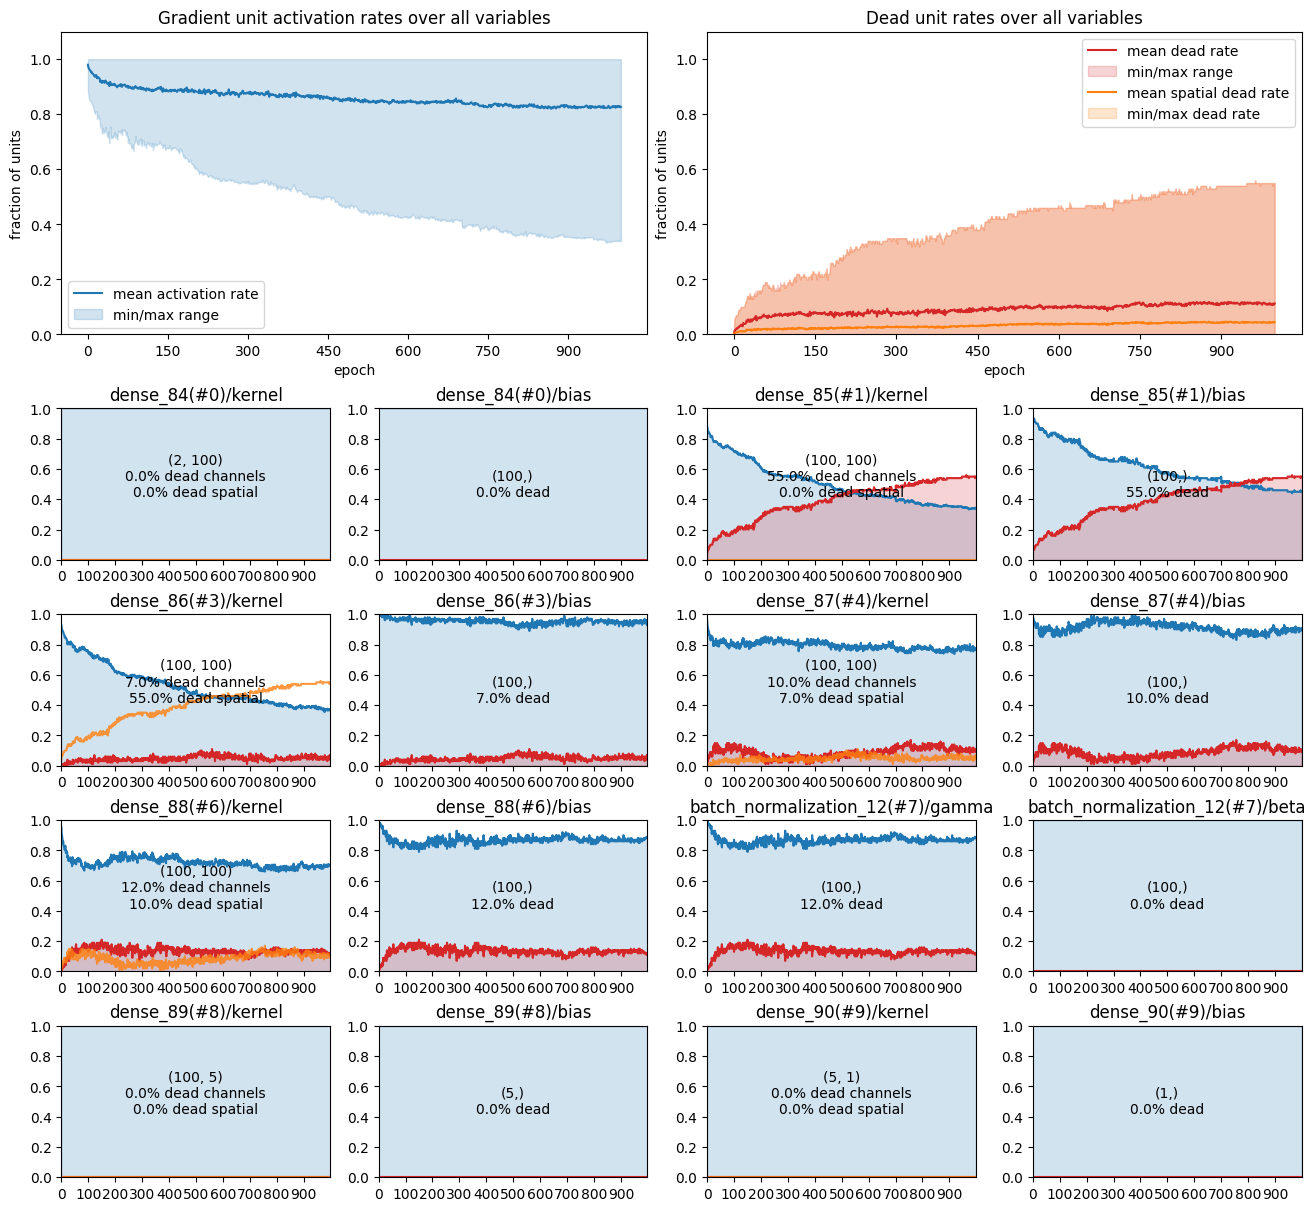

In [34]:
tinstr.plot_activity_history(gradients)

## Basic Near-Zero Gradients Report

The `kernel` (weights) of the second layer get to around 60% neuron death by the end. There's a slow but steady increase from near 0% at the start. So there's no obvious point where it _suddenly_ looses neurons (which can happen). In this case starting at the last epoch is as good as any.

Let's generate a train-explainer report...

In [43]:
texpl.explain_near_zero_gradients([variables, gradients, outputs, output_gradients], target_layer_idx, epoch=999)

Examining layer #1 at iteration 999:
  layer:               dense_85
  units:               100
  weights:             10000
  input from layers:   [0]
  output to layers:    [2]
  near-zero gradients: 6606 (66.1%) = 0

Let:
  A_0      <- input activation to target layer
  W_l      <- weights of target layer
  Z_l      <- pre-activation output of target layer
  S_l      <- effect of activation function as element-wise multiplier
  A_l      <- output activation of target layer

Forward pass...
A_0 - input value:
  shape:             (12, 100) -> total values: 1200
  summary:           55.9% near-zero
W_l - weights of target layer:
  shape:             (100, 100) -> total values: 10000
  summary:           1.0% near-zero
  corresponding to near-zero gradients: 1.0% near-zero
compute Z_l = A_0 . W_l + b_l:
  inputs examined:   A_0, W_l
  summary:           1.0% near-zero
Z_l - pre-activation output:
  shape:             (12, 100) -> total values: 1200
  summary:           86.5% negative, 

So what can we infer from this?

First, let's pull out the major points of interest:

> ```
> A_0 - input value:
>   summary:           55.9% near-zero
> Z_l - pre-activation output:
>   summary:           86.5% negative, 70.0% of units always near-zero or negative across all batch dims
> compute dJ/dZ_l = dJdA_l (.) S_l:
>   summary:           89.5% near-zero, of which 96.6% are affected by near-zero values from S_l
> ```

The core problem is that `Z_l` (the pre-activation layer values) is producing negative values. This is leading to `S_l` (the post-activation layer outputs) being mostly zero. This has flow-on effects during backprop, where the zeros in `S_l` leads to zeroing out of most of the inbound gradients (dJ/dZ) before variable gradients are computed.

It's interesting to note that weight gradients (dJ/dW) are not as badly affected as the first part of the inbound gradients (dJ/dZ). This gives a clue as to how it's possible for networks to sometimes recover from dead units.

A quick clarification before we continue: I've misused `A_0` to refer to the input to the target layer, regardless of whether it's the first layer's input or any other. That's because I can't think of a cleaner way to represent $A_{l-1}$ in code. I'll continue to use `A_0` with this somewhat corrupted meaning throughout this notebook.


## Verbose Report

The `explain_near_zero_gradients()` function has a verbose mode where it gives more of its internal calculations and presents more detailed statistics:


In [42]:
texpl.explain_near_zero_gradients([variables, gradients, outputs, output_gradients], target_layer_idx, epoch=999, verbose=True)

Examining layer #1 at iteration 999:
  layer:               dense_85
  units:               100
  weights:             10000
  input from layers:   [0]
  output to layers:    [2]
  near-zero gradients: 6606 (66.1%) = 0

Let:
  A_0      <- input activation to target layer
  W_l      <- weights of target layer
  Z_l      <- pre-activation output of target layer
  S_l      <- effect of activation function as element-wise multiplier
  A_l      <- output activation of target layer
  PZN      <- breakdown of values into (P)ositive, near-(Z)ero, or (N)egative
  x . y    <- matmul (aka dot product)
  x (.) y  <- element-wise multiply

Forward pass...
A_0 - input value:
  shape:             (12, 100) -> total values: 1200
  summary:           55.9% near-zero (= 0), 0.0% of units always near-zero across all batch dims
  value percentiles: [0, 25, 50, 75, 100] -> [0.         0.         0.         0.47027892 1.9822227 ]
  PZN counts/sums:   Z: 671.0 = Σ 0.0, P: 529.0 = Σ 336.7
  PZN counts/means: 

**Explaining verbose output**

There's a lot in there, which is why I start with the non-verbose version.

Before we try to draw any conclusions, let's pull out a few things and explain what's going on.

First up, `A_0`, the input to the target layer:

> ```
> A_0 - input value:
>   shape:             (12, 100) -> total values: 1200
>   summary:           55.9% near-zero (= 0), 0.0% of units always near-zero across all batch dims
>   value percentiles: [0, 25, 50, 75, 100] -> [0.         0.         0.         0.47027892 1.9822227 ]
>   PZN counts/sums:   Z: 671.0 = Σ 0.0, P: 529.0 = Σ 336.7
>   PZN counts/means:  Z: 55.9% x 0.000000, P: 44.1% x 0.636509
> ```

55.9% near-zero. But that's not the whole picture. That's only on average. Across all samples available, all units are active at some point - there's no dead units.

"PZN" refers to the positive, near-zero, and negative classifications that I mentioned earlier. The above shows how `A_0` is made up of 44.1% positive values (529 in absolute numbers) that together sum to 336.7. Alternatively, you could view that as 529 values with a mean of 0.637. It also shows that it is made up of 55.9% zero or near-zero values. More formally, the two PZN rows list stats for each PZN class in each of two styles:
* `{count}={sum}` (eg: `529.0 = Σ 336.7`) - the total number of elements in the class, along with the sum of those values
* `{percent}={mean}` (eg: `44.1% x 0.636509`) - the percentage of elements in the tensor that fall into the class, along with their mean value

The definition of "near-zero" is dynamically calculated for each tensor. By default it's computed with a threshold at the 1st-percentile. This means that healthy tensors with a nice range of values will always have exactly 1.0% near-zero values. For "non-healthy" tensors, it might pick the threshold at exactly zero. The bit in brackets here tells us that it's chosen exactly-zero as the threshold for `A_0`: `55.9% near-zero (= 0)`.

Now, jump down to the calculation of `dJ/dZ_l` (the first part of backprop calculation within the layer):
> ```
> compute dJ/dZ_l = dJdA_l (.) S_l:
>   inputs examined:   dJ/dA_l, S_l
>   summary:           89.5% near-zero, of which 96.6% are affected by near-zero values from S_l
>   PZN combinations:  NZ: 455.0 = Σ 0.00000000, PZ: 384.0 = Σ 0.00000000, ZZ: 199.0 = Σ 0.00000000, NP: 84.0 = Σ -0.00127121, PP: 42.0 = Σ 0.00117339, ZP: 36.0 = Σ 0.00000000
>   PZN combinations:  NZ: 37.9% x 0.0000000000, PZ: 32.0% x 0.0000000000, ZZ: 16.6% x 0.0000000000, NP: 7.0% x -0.0000151335, PP: 3.5% x 0.0000279379, ZP: 3.0% x 0.0000000000
> ```

The summary says it all: the problem is that `S_l` has many zero or near-zero values. But we can see that for ourselves if we look closer. This block of the report and others like it extend the PZN concept through the matrix operations. Here we have variables `dJdA_l` and `S_l` that are each separately analysed in terms of their numbers of positive, near-zero, and negative values, and then the combinations of those three classes are analysed in the result. Thus we have 455 element-wise multiplications resulting from `dJdA_l` being negative and `S_l` being zero or near-zero. Looking across we see that we have NZ + PZ + ZZ combinations spanning a sum of 86.5% of the total elements in the resultant matrix. In other words, it doesn't matter much what the values of `dJdA_l` are, because most are getting multiplied against zeros from `S_l`.

The next block in the report breaks that out further by i) reporting on the same stats but just for those element that are near-zero, and ii) doing automatic analysis of the PZN combinations:
> ```
> dJ/dZ_l 89.5% near zero (= 0):
>   PZN combinations:  NZ: 455.0 = Σ 0.000, PZ: 384.0 = Σ 0.000, ZZ: 199.0 = Σ 0.000, ZP: 36.0 = Σ 0.000
>   PZN combinations:  NZ: 42.4% x 0.000, PZ: 35.8% x 0.000, ZZ: 18.5% x 0.000, ZP: 3.4% x 0.000
>   96.6% affected by near-zero values from S_l
>   100.0% affected by near-zero values from either input
>   21.9% affected by near-zero values from dJ/dA_l
> ```

The automatic analysis isn't perfect. It repeats itself a little. But it's got the the crux point quite nicely (96.6% of the resultant near-zero values are caused by `S_l`) and perhaps shown us something we wouldn't have so easily identified ourselves (21.9% of near-zero values are contributed to by `dJ/dA_l` being near-zero).




**Conclusion revisions from verbose report**

Our overal conclusion hasn't changed. But some things have become a little more refined. The non-verbose report applies some heuristics to drill down to what it believes to be the most _pertinent_ information, but it sometimes gets that wrong.

> ```
> A_0 - input value:
>   brief:           55.9% near-zero
>   verbose:         55.9% near-zero (= 0), 0.0% of units always near-zero across all batch dims
> ```

We first thought that 55.9% of `A_0` was near-zero. It turns out that such a statement is only true on average. There are in fact no dead units. `A_0` is likely not the cause of our problems.

> ```
> W_l - weights of target layer:
>   shape:             (100, 100) -> total values: 10000
>   summary:           1.0% near-zero (< 0.0019927648827433586)
>   value percentiles: [0, 25, 50, 75, 100] -> [-1.1143992e+00 -1.0876491e-01  8.4966136e-04  1.1162956e-01  4.7653157e-01]
> ```

I didn't bring this up before, but I'll briefly mention the weights tensor. In my experience, it's pretty typical that the weights are not directly the cause of dead units - ie: dead units are usually _not_ caused by the weights tending towards zero. The above is pretty typical, with weights falling roughly equally on either side of zero.

> ```
> Z_l - pre-activation output:
>   brief:             86.5% negative, 70.0% of units always near-zero or negative across all batch dims
>   verbose:           86.5% negative, 1.0% near-zero (< 0.017070427536964417), 70.0% of units always near-zero or negative across all batch dims
> ```

Further corroborating the commentary about the weights, our problems with `Z_l` are specifically on its negative values. The number of near-zero values is exactly according to definition.

> ```
> compute dJ/dW_l = A_0^T . dJ/dZ_l:
>    brief:           66.1% near-zero, of which 99.0% are affected by near-zero values from dJ/dZ_l
> dJ/dW_l 66.1% near zero (= 0):
>    verbose:         99.0% affected by near-zero values from dJ/dZ_l
>    verbose:         56.4% affected by near-zero values from A_0^T
> ```

While there are no dead units from `A_0`, and while the negative `Z_l` is our biggest concern, the high percentage of zero values from `A_0` is also having a noticeable impact.


## Resolutions
The next step would be to investigate how to solve these problems.

I don't yet have any generic advice.

Instead, in the following notebook I delve into a more extreme version of this problem in a particular problem domain and I look at solutions there:
* `doc/blog-202503/gradient-collapse.ipynb`

## Theory behind Near-zero Gradient Explainer
The `explain_near_zero_gradients()` function has to reverse engineer some aspects of both the forward and backprop operation of the network. This is made more complex by the fact that technologies like `GradientTape` and `AutoDiff` eliminate the need for layers to expose details about their operation that can be used for mathematical analyses. This section of the docs explains the maths used to perform that reverse-engineering.

To explain the underlying cause of a zero or nero-zero gradient, we need to examine the maths behind the gradient computation. The gradient matrix of the weights for a given layer $l$ is defined by:

$$\frac{\partial{J}}{\partial{W_l}} ≈ A_{l-1} \cdot S_l \cdot \frac{\partial{J}}{\partial{Z_{l+1}}}$$


where:
* $J$ = loss
* $A_{l-1}$ = layer $l-1$ output after activation function applied, ie: output from previous layer as input to layer $l$
* $S_l$ = $A_l > 0$ = matrix of 0s and 1s that represents effect of activation function at layer $l$, assuming ReLU activation
* $\frac{\partial{J}}{\partial{Z_{l+1}}}$ = backprop from next layer

What we really want to compute can be described via a bayesion formalism:

$$P(A_{l-1} \text{causal} | \frac{\partial{J}}{\partial{W_l}} ≈ 0)$$
$$P(S_{l} \text{causal} | \frac{\partial{J}}{\partial{W_l}} ≈ 0)$$
$$P(\frac{\partial{J}}{\partial{Z_{l+1}}} \text{causal} | \frac{\partial{J}}{\partial{W_l}} ≈ 0)$$

To do that fully and accurately gets quite involved. So, rather, I merely report on the reverse and allow the reader to draw their own inferences. This is made up of estimates of the likelihood of obtaining zero or near-zero gradients due to each of the three components alone:

$$P(\frac{\partial{J}}{\partial{W_l}} ≈ 0 | A_{l-1})$$

$$P(\frac{\partial{J}}{\partial{W_l}} ≈ 0 | S_l)$$

$$P(\frac{\partial{J}}{\partial{W_l}} ≈ 0 | \frac{\partial{J}}{\partial{Z_{l+1}}})$$

And it includes the two groupings of adjacent pairs of component:

$$P(\frac{\partial{J}}{\partial{W_l}} ≈ 0 | A_{l-1} \cdot S_l)$$

$$P(\frac{\partial{J}}{\partial{W_l}} ≈ 0 | S_l \cdot \frac{\partial{J}}{\partial{Z_{l+1}}})$$

The following sub-sections go into detail for each calculation.

### Differences in layers and notation
How the gradient equation is operationalised depends on the kind of layer. The gradient equation above is complete for a simple dense layer, but becomes more complex when considering a convolutional layer, for example.

Firstly, the computation of an output activation at a given spatial position depends only on a subset of input activations. To cope with that I use the following notation to indicate only the relevant subset of the matrix for the given gradient is to be considered:

$$\lfloor A_{l-1} \rfloor_{\text{subset}}$$

Secondly, any given weight contributes to the value of activation activations at multiple spatial positions. This means that I cannot simply compute a boolean yes/no that a given gradient will be zero because of a zero value in the input activations. Rather, typically I'll only know that a certain fraction of the applicable values are tending in that direction, but I won't have the information about subsequent processing that might happen to consider only the non-zero values. Thus I'll be computing indicative probabilities based on the fraction of problematic states versus the whole. This will be represented as follows:

$$\text{fraction}(A_{l-1} \approx 0) = \frac{|A_{l-1} \approx 0|_\text{cardinality}}{|A_{l-1}|_\text{cardinality}}$$

This fraction-based reporting may will be relevant for all layer types anyway due to the fact that multiple samples are grouped together into a batch, and a single gradient is computed across the batch.

### Input activations as causes
Any given hidden layer has one or more previous layers as input, with their output activations $A_{l-1}$ holding the values that become inputs.

There are multiple ways in which those inputs can contribute to near-zero gradients in the target layer, but thanks to the magic of the chain rule and the gradient equation, we only need to consider the raw values of $A_{l-1}$.

The following general guide applies for estimating the gradients in the target layer if all input layer activations fall into a particular range:

|$A_{l-1}$|Gradient|Description|
|---|---|---|
|$A_{l-1} \gg 0$|unknown|$A$ does not directly contribute to near-zero gradients.|
|$A_{l-1} \approx 0$|$\approx 0$|Gradient could be kept large by a large backprop gradient, but it probably won't.|
|$A_{l-1} = 0$|$= 0$|All gradients will definitely be zero, regardless of other components|
|$A_{l-1} < 0$|n/a|Negative inputs are not possible if the input layers use ReLU activation function. Otherwise the gradient depends on the combination of $A_{l-1}$ and the sign of $W_{l}$.

Thus we have the following equation for computing the independent influence of the input activations on near-zero gradients:

$$P(\frac{\partial{J}}{\partial{W_{l,ij}}} \approx 0|A_{l-1}) = \text{fraction}(\lfloor A_{l-1} \rfloor_{\text{subset,ij}} \approx 0)$$

This varies a little by layer type:
* Dense - all $A_{l-1}$ contribute, fraction must be computed over batch dimension only
* Conv - $A_{l-1,ij}$ values within the kernel size

### Layer activation as cause
The gradient equation does not incorporate the weights $W_l$ or the bias $b_l$ of the target layer, nor does it incorporate its pre-activation output $Z_l$ or its raw activation values $A_l$. Rather, it considers only

$$\frac{\partial{A_l}}{\partial{Z_l}} \approx S_l$$

where, for ReLU activation layers:
$$S_l = A_l > 0$$

For ReLU activation layers, $S_l$ is a matrix of 0s and 1s as follows. This can be seen in how $\frac{\partial{A_l}}{\partial{Z_l}}$ varies by value of $Z_l$:

|$Z_l$|$\frac{\partial{A_l}}{\partial{Z_l}}$|Description|
|---|---|---|
|$Z_{l,ij} > 0$|$1.0$|ReLU activation function simply passes value through unchanged, which is equivalent of $1 \cdot z$, and thus a constant $1.0$ gradient.|
|$Z_{l,ij} < 0$|$0.0$|ReLU activation function clips input to zero, leading to constant $0.0$ gradient.|
|$Z_{l,ij} = 0$|$0.0$|Edge case that depends on internal implementation, but we treat as for $Z_{l,ij} < 0$ because we cannot distinguish otherwise.|

Note that $S_l$ is applied in an element-wise fashion, not as a strict matrix multiplication.

Thus we have the following equation for computing the independent influence of the target layer activation on near-zero gradients:

$$P(\frac{\partial{J}}{\partial{W_{l,ij}}} \approx 0|S_l) = \text{fraction}(\lfloor S_l \rfloor_{\text{subset,ij}} = 0)$$

### Layer activation components as cause
However that's not all for the effect of $S_l$. Its value is derived based on multiple sub-components, and we'll be interested to know which of those sub-components have contributed to the state of $S_l$:

$$S_l = A_l > 0 = (A_{l-1} \cdot W_l + b_l) > 0$$

In particular, for a given $S_{l,ij} = 0$, we have at least three possible and useful explanations:
* $\lfloor A_{l-1} \rfloor_\text{subset} = 0$, and $W_l$ had no effect
* $\lfloor W_l \rfloor_\text{subset} \le 0$, and $A_{l-1}$ had no effect
  * (remember that $A_{l-1}$ is always positive for ReLU activation, so a negative weight leads to a zero output)
* $\lfloor A_{l-1} \cdot W_l \rfloor_\text{subset} < b_l$

In otherwords, $A_{l-1}$ and $W_l$ have a chance of leading to a zero gradient on their own, but there is also a separate scenario where only their combination leads to a zero gradient. Knowing which scenario is applicable for a given problem is extremely useful.

Now, we have easy direct access to captured values of $A_{l-1}$ and $W_l$. But the exact form of the calculation of $A_{l-1} \cdot W_l$ varies by layer type, so we cannot easily compute that. Thankfully we don't have to, as $A_l \le 0$ is a good enough proxy.

Thus we have the following independent sub-component influences on near-zero gradients in the target layer:

$$P(\frac{\partial{J}}{\partial{W_{l,ij}}} \approx 0|A_{l-1}) = \text{fraction}(\lfloor A_{l-1} \rfloor_{\text{subset,ij}} \approx 0)$$

$$P(\frac{\partial{J}}{\partial{W_{l,ij}}} \approx 0|W_l) = \text{fraction}(\lfloor W_l \rfloor_{\text{subset,ij}} \approx 0 \text{ or } \lfloor W_l \rfloor_{\text{subset,ij}} < 0)$$

But notice that the first is a duplicate of one we've already identified.

### Backprop values as cause
The final component of the weight gradient equation is the backprop from the later layers:

$$\frac{\partial{J}}{\partial{Z_{l+1}}}$$

In a normal training loop we wouldn't usually collect that information. So this could lead to some interesting questions. Thankfully, we've already got a custom training loop, and we can collect what we want. This means that we can directly compute:

$$P(\frac{\partial{J}}{\partial{W_l}} \approx 0| \frac{\partial{J}}{\partial{Z_{l+1}}}) = \text{fraction}( \lfloor \frac{\partial{J}}{\partial{Z_{l+1}}} \rfloor_\text{subset,ij} \approx 0 )$$

### Backprop values as cause - estimated
In an earlier version I originally implemented an way to estimate the backprop values without directly measuring them. I'll leave this theory here for prosperity, and because the implementation is still there in the code as a fallback.

While we might not directly collect backprop gradients, we do collect some other information that can be used to guess at the backprop values.

We want the following:

$$P(\frac{\partial{J}}{\partial{W_l}} \approx 0| \frac{\partial{J}}{\partial{Z_{l+1}}})$$

But instead what we have available for use is:

$$\frac{\partial{J}}{\partial{W_{l+1}}}$$

Thankfully, that is is only one step removed from what we need:

$$\frac{\partial{J}}{\partial{W_{l+1}}} = \frac{\partial{J}}{\partial{Z_{l+1}}} \cdot \frac{\partial{Z_{l+1}}}{\partial{W_{l+1}}} = \frac{\partial{J}}{\partial{Z_{l+1}}} \cdot A_l$$

$$\frac{\partial{J}}{\partial{Z_{l+1}}} = \frac{\partial{J}}{\partial{W_{l+1}}} \cdot A_l^{-1}$$

Now, we almost certainly cannot invert $A_l$ as we're explicitly using all this logic in the case where we're searching for zeros, which makes $A_l$ non-singular. As a possibly naive first approximation, we'll _hope_ that the following holds (where $A_l^+$ is the Moore Penrose pseudo-inverse):

$$\frac{\partial{J}}{\partial{Z_{l+1}}} \approx \frac{\partial{J}}{\partial{W_{l+1}}} \cdot A_l^+$$

$$P(\frac{\partial{J}}{\partial{W_l}} \approx 0|\frac{\partial{J}}{\partial{Z_{l+1}}}) \approx P(\frac{\partial{J}}{\partial{W_l}} \approx 0|\frac{\partial{J}}{\partial{W_{l+1}}} \cdot A_l^+)$$

Now, gradients may legitimately be positive or negative, so we are only interested in values near zero. Secondly, we now have another equation with sub-components that we may be interested in. However, we'll ignore $A_l^+$ as an independent value because its not directly captured value, and its complex derivation makes any interpretation from it difficult.

Thus we have the following final independent contributions towards near-zero gradients:

$$P(\frac{\partial{J}}{\partial{W_{l,ij}}} \approx 0|\frac{\partial{J}}{\partial{Z_{l+1}}}) = \text{fraction}( \lfloor \frac{\partial{J}}{\partial{W_{l+1}}} \cdot A_l^+ \rfloor_\text{subset,ij} \approx 0 )$$

$$P(\frac{\partial{J}}{\partial{W_{l,ij}}} \approx 0|\frac{\partial{J}}{\partial{Z_{l+1}}}) = \text{fraction}( \lfloor \frac{\partial{J}}{\partial{W_{l+1}}} \rfloor_\text{subset,ij} \approx 0)$$

By the way, in some tentative experiments, this estimation approach works surprisingly well and the train explainer still gets similar results.

### Combined input and target activation as cause
_todo_

### Combined target activation and backprop as cause
_todo_


### Summary
With all that in place, we have identified ways in which the following raw values can contribute to near-zero gradients:
* $A_{l-1}$
* $W_l$
* $A_l$
* $W_{l+1}$

### Further reading
If the maths went over your head, and you'd like to understand it better, I have a blog post where I've clearly explained gradient computation in deep neural networks:
* https://medium.com/ai-advances/grokking-gradients-in-deep-neural-networks-6849fa42f1fa
